# 1. Environment

In [7]:
# Test environment
import torch; print('PyTorch:', torch.__version__, 'CUDA:', torch.cuda.is_available())
if torch.cuda.is_available() :
    print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

PyTorch: 2.4.1+cpu CUDA: False
device : cpu


In [4]:
from matcha.models.matcha_tts import MatchaTTS; print('MatchaTTS OK')
from phonemizer import phonemize; print('Phonemizer OK')

MatchaTTS OK
Phonemizer OK


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import Matcha components
from matcha.models.matcha_tts import MatchaTTS
from matcha.text import text_to_sequence
from matcha.utils.utils import intersperse
from matcha.hifigan.models import Generator as HiFiGAN
from matcha.hifigan.config import v1
from matcha.hifigan.env import AttrDict

# 2. Run Inference

In [12]:
# Load models and checkpoints

# tts model
MATCHA_CHECKPOINT = r"models\matcha_ljspeech.ckpt"

# Vocoder (Mel-spectrograms -> Audio)
VOCODER_PATH = r"vocoders\hifigan_T2_v1"

In [13]:
# Load model

print(f"Loading Matcha checkpoint from: {MATCHA_CHECKPOINT}")
model = MatchaTTS.load_from_checkpoint(MATCHA_CHECKPOINT, map_location=device)
model.eval()
model.to(device)
print("Matcha-TTS loaded successfully.")

Loading Matcha checkpoint from: models\matcha_ljspeech.ckpt


d:\Work Life\Studies\M2 ISI\S1\2 - Machine learning avancé\MLA Projet\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\lightning\fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

Matcha-TTS loaded successfully.


In [22]:
# Text processing

def process_text(text, device):
    
    # a. Convert text to phoneme IDs
    # 'english_cleaners2' handles number expansion and phonemization via espeak
    sequence = text_to_sequence(text, ['english_cleaners2'])
    sequence = sequence[0]
    print(f"sequence : {sequence}")
    
    # b. Intersperse with '0' (blank token) for the flow matching stability
    sequence = intersperse(sequence, 0)
    print(f"sequence after intersperse(0) : {sequence}")
    
    # c. Convert to tensor
    x = torch.tensor(sequence, dtype=torch.long, device=device)[None] # Add batch dim
    x_lengths = torch.tensor([x.shape[-1]], dtype=torch.long, device=device)
    
    return x, x_lengths

sequence : [50, 83, 54, 156, 57, 135, 16, 65, 156, 87, 158, 54, 46]
sequence after intersperse(0) : [0, 50, 0, 83, 0, 54, 0, 156, 0, 57, 0, 135, 0, 16, 0, 65, 0, 156, 0, 87, 0, 158, 0, 54, 0, 46, 0]
Phoneme Sequence IDs: tensor([[  0,  50,   0,  83,   0,  54,   0, 156,   0,  57,   0, 135,   0,  16,
           0,  65,   0, 156,   0,  87,   0, 158,   0,  54,   0,  46,   0]])

Running Matcha Inference (Flow Matching)...
Generated Mel Shape: torch.Size([1, 80, 80])


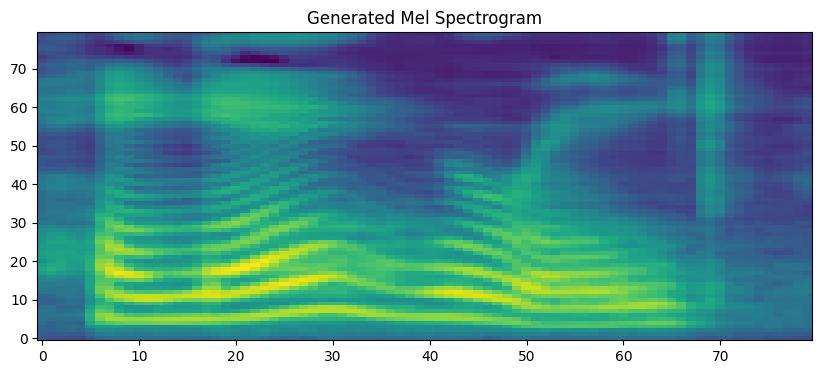

In [28]:
# Inference

text_input = "Hello world"

# Step A: Process Text
x, x_lengths = process_text(text_input, device)
print(f"Phoneme Sequence IDs: {x}")

# Step B: Generate Mel-Spectrogram (The Core Flow Matching)
# n_timesteps: Lower = faster (2-4), Higher = better quality (10-50)
print("\nRunning Matcha Inference (Flow Matching)...")
with torch.inference_mode():
    output = model.synthesise(
        x, 
        x_lengths, 
        n_timesteps=10, 
        temperature=0.667, 
        length_scale=1.0 # 1.0 = normal speed, 0.8 = faster speech
    )

mel = output['mel']

print(f"Generated Mel Shape: {mel.shape}")

# Visualisation

plt.figure(figsize=(10, 4))
plt.imshow(mel.squeeze().cpu().numpy(), origin='lower', aspect='auto')
plt.title("Generated Mel Spectrogram")
plt.show()

In [34]:
# Generate audio

try:
    # Attempt to load HiFi-GAN. 

    vocoder_conf = AttrDict(v1)
    vocoder = HiFiGAN(vocoder_conf).to(device)
    
    
    VOCODER_PATH = Path(VOCODER_PATH)
    if not VOCODER_PATH.exists():
        print(f"Vocoder not found at {VOCODER_PATH}. Skipping audio generation.")
    else:
        vocoder.load_state_dict(torch.load(VOCODER_PATH, map_location=device)['generator'])
        vocoder.eval()
        
        print("\nVocoding Mel to Audio...")
        with torch.inference_mode():
            audio = vocoder(mel).clamp(-1, 1).cpu().squeeze()
            
        import soundfile as sf
        sf.write('audios\output_audio.wav', audio.numpy(), 22050)
        print("output_audio.wav")

except Exception as e:
    print(f"\nCould not run vocoder: {e}")

C:\Users\adjal\AppData\Local\Temp\ipykernel_20784\4123293175.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocoder.load_state_dict(torch.load(VOCODER_PATH, map_locati


Vocoding Mel to Audio...
output_audio.wav
